In [1]:
import os
from dataset import DatasetGenerator
from utils import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from model import Facenet
from sklearn.metrics import accuracy_score
import warnings

warnings.filterwarnings("ignore")

os.environ["TFF_CPP_MIN_LOG_LEVEL"] = "2"

In [2]:
LR = 1e-3
BATCH_SIZE = 128
IMAGE_SIZE = (160, 160)

In [3]:
CWD = os.getcwd()
DATA_PATH = os.path.join(CWD, 'data/Extracted Faces')

In [4]:
train_list, test_list = train_test_split(DATA_PATH, split = 0.8)

In [5]:
def plot_triplets(data_generator, num_triplets):

    def show(ax, image, title):
        ax.imshow(image)
        ax.set_title(title)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        

    f, axs = plt.subplots(num_triplets, 3, figsize = (10, 15))
    for i in data_generator:
        anchor, positive, negative = i
        for k in range(num_triplets):
            show(axs[k, 0], anchor[k], "anchor")
            show(axs[k, 1], positive[k], "positive")
            show(axs[k, 2], negative[k], "negative")
            k += 1
        break

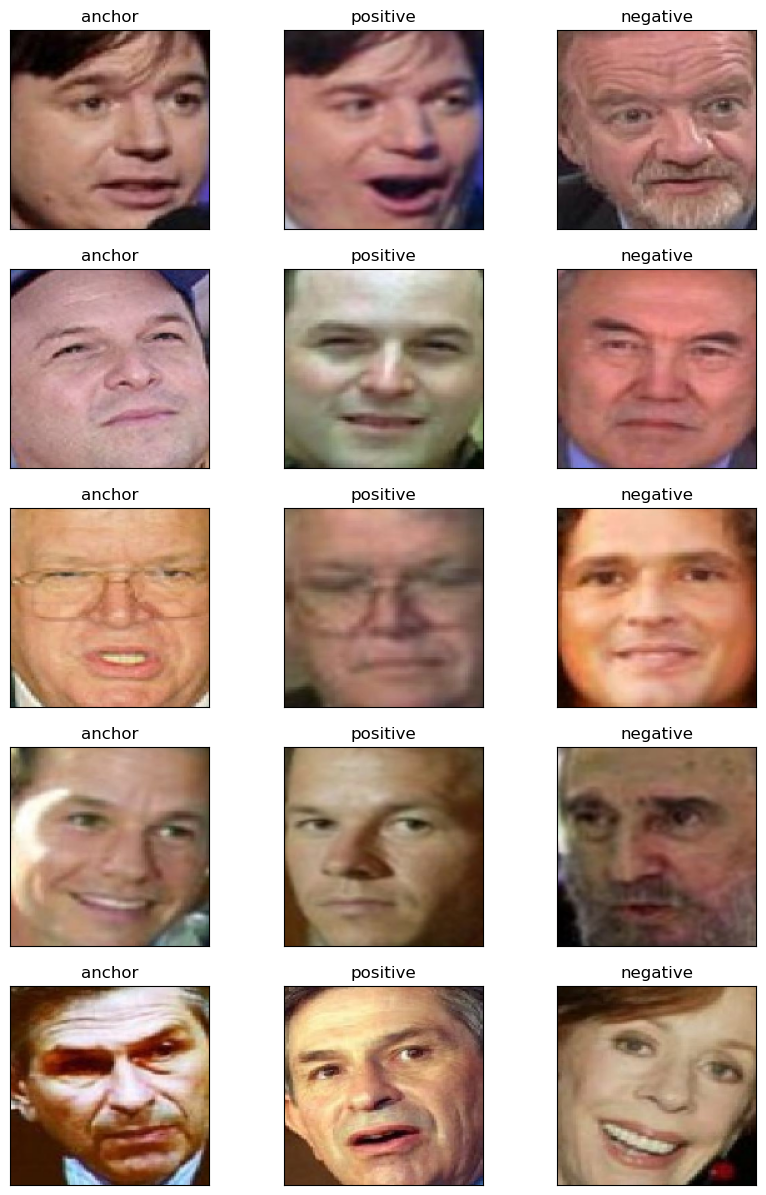

In [6]:
num_examples = 5
data_generator = DatasetGenerator(DATA_PATH, train_list, preprocess = False, batch_size = num_examples)
plot_triplets(data_generator, num_examples)

In [7]:
train_data_generator = DatasetGenerator(DATA_PATH, train_list, batch_size=BATCH_SIZE)
test_data_generator = DatasetGenerator(DATA_PATH, test_list, batch_size=BATCH_SIZE)

In [8]:
epochs = 5
model = Facenet(freeze_layers = 225)
history = model.fit(train_data_generator, epochs = epochs)

100%|██████████| 90/90 [06:04<00:00,  4.05s/batch]


Epoch 1: Loss on train = 0.02883


100%|██████████| 90/90 [06:34<00:00,  4.38s/batch]


Epoch 2: Loss on train = 0.01370


100%|██████████| 90/90 [06:31<00:00,  4.35s/batch]


Epoch 3: Loss on train = 0.00998


100%|██████████| 90/90 [06:12<00:00,  4.14s/batch]


Epoch 4: Loss on train = 0.00798


100%|██████████| 90/90 [06:08<00:00,  4.10s/batch]


Epoch 5: Loss on train = 0.00570


In [9]:

def get_prediction(encoding1, encoding2, threshold = 1.4):
    distances =  np.sum(np.square(encoding1 - encoding2), axis = -1)
    predictions = np.where(distances < threshold, 0, 1)
    return predictions

def evaluate_facenet(data_generator):
    ap_all_preds = []
    an_all_preds = []
    for item in data_generator:
        a, p, n = item
        a_predict = model.predict(a, verbose = 0)
        p_predict = model.predict(p, verbose = 0)
        n_predict = model.predict(n, verbose = 0)
        ap_preds = get_prediction(a_predict, p_predict)
        an_preds = get_prediction(a_predict, n_predict)
        ap_all_preds = np.append(ap_all_preds, ap_preds)
        an_all_preds = np.append(an_all_preds, an_preds)

    preds = np.append(ap_all_preds, an_all_preds)
    true = np.array([0] * len(ap_all_preds) + [1] * len(an_all_preds))
    print(f"\nAccuracy of model: {accuracy_score(true, preds) * 100:.2f}%\n")


evaluate_facenet(test_data_generator)



Accuracy of model: 89.31%



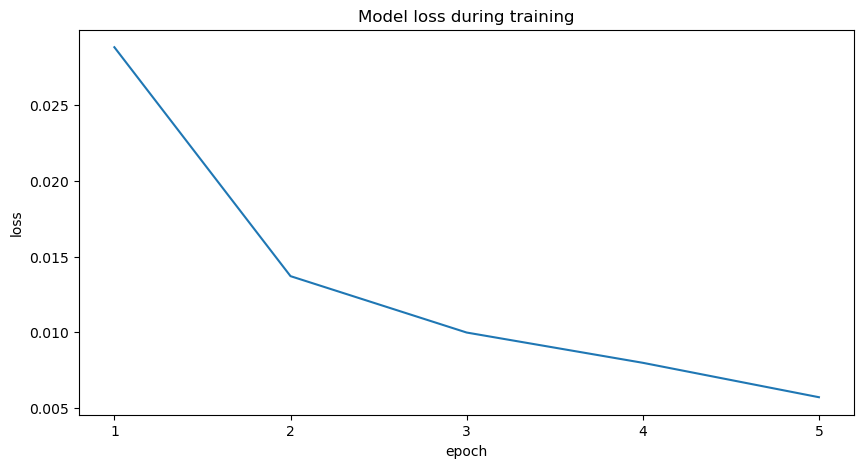

In [10]:
plt.figure(figsize=(10, 5))
plt.plot([epoch for epoch in range(1, epochs + 1)], history['train_loss'])
plt.xticks(range(1, epochs + 1))
plt.title('Model loss during training')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show();

## Clustering

In [11]:
from sklearn.cluster import DBSCAN
from utils import cluster_data
import shutil

In [12]:
model = Facenet(default_weights=False)

In [13]:
data_dict, images, images_dir = cluster_data(test_list)
print(f'''Number of images: {len(images)}
Number of unique faces: {len(data_dict)}''')

Number of images: 64
Number of unique faces: 6


In [14]:
encodings = []
for image in images:
    image = np.reshape(image, (1,) + IMAGE_SIZE + (3,))
    encoding = model.predict(image, verbose = 0)
    encodings.append(encoding)

encodings = np.squeeze(np.array(encodings))

In [24]:
clusterer = DBSCAN(eps = 0.85, min_samples = 5, metric = "euclidean", n_jobs = -1)
clusterer.fit(encodings)
labels_id = np.unique(clusterer.labels_)
labels_id

array([0, 1, 2, 3, 4, 5])

In [25]:
labels_id = np.unique(clusterer.labels_)
num_unique_faces = len(np.where(labels_id > -1)[0])
print('Number of unique faces found: ', num_unique_faces)

Number of unique faces found:  6


In [26]:
if os.path.exists(os.path.join(CWD, 'cluster_results')):
    shutil.rmtree(os.path.join(CWD, 'cluster_results'))
clusters_path = os.path.join(CWD, 'cluster_results')
images_path = os.path.join(CWD, 'data/Face Data')
os.makedirs(clusters_path)
for label in labels_id:
    os.makedirs(os.path.join(clusters_path, str(label)))
    idxs = np.where(clusterer.labels_ == label)[0]
    for idx in idxs:
        shutil.copy(os.path.join(images_path, images_dir[idx][0], images_dir[idx][1]), 
                    os.path.join(clusters_path, str(label), images_dir[idx][0] + '_'+ images_dir[idx][1]))